In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pickle
import os

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

In [32]:
df=pd.read_csv('forest_fire_dataset_processed.csv')

In [33]:
df.head()

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,1,6,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,BR
1,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,BR
2,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,BR
3,4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,BR
4,5,6,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire,BR


In [34]:
x=df.drop(columns=['Classes'])
y=df['Classes']

In [35]:
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=100) #using same random_state as per EDA

# Training Pipeline

In [36]:
def train_preprocessing_pipeline(x_train, y_train):
    df=pd.concat([x_train, y_train], axis=1)
    df=df.reset_index(drop=True)
    
    #adding features
    df['day_name']=pd.to_datetime(df[['day', 'month', 'year']]).apply(lambda x: x.strftime("%a"))
    df['month']=pd.to_datetime(df[['day', 'month', 'year']]).apply(lambda x: x.strftime("%b"))
    #dropping unnecessary column
    df=df.drop(columns=['year', 'day', 'BUI', 'FWI'])
    
    #splitting into numerical and categorical values
    num_df=df.drop(columns=['month', 'day_name', 'Classes', 'Region'])
    cat_df=df[['month', 'day_name', 'Classes', 'Region']]
    
    #Scaling
    scaler=StandardScaler()
    num_array=scaler.fit_transform(num_df)
    num_df=pd.DataFrame(num_array, columns=num_df.columns)
    if not os.path.isdir('Scaling'):
        os.mkdir('Scaling')
    pickle.dump(scaler, open('Scaling/Scaler_Classification.pickle', 'wb'))
    
    #encoding
    cat_df['month']=cat_df['month'].map({'Aug':3, 'Jul':2, 'Jun':1, 'Sep':0})  
    cat_df['Region']=cat_df['Region'].map({'SBAR':1, 'BR':0})
    cat_df['Classes']=cat_df['Classes'].map({'fire':1, 'not fire':0})
    encoder=OneHotEncoder(drop="first", sparse=False)
    day_names_array=encoder.fit_transform(cat_df[['day_name']])
    day_names=pd.DataFrame(day_names_array, columns=encoder.get_feature_names_out())
    if not os.path.isdir('Encoder'):
        os.mkdir('Encoder')
    pickle.dump(encoder, open('Encoder/encode_dayname.pickle', 'wb'))
    cat_df=cat_df.drop(columns=['day_name'])
    cat_df=pd.concat([cat_df, day_names], axis=1)
    
    final_data=pd.concat([num_df, cat_df], axis=1)
    x=final_data.drop(columns=['Classes'])
    y=final_data['Classes']
    return x, y

# Testing Pipeline

In [37]:
def test_preprocessing_pipeline(x_test, y_test):
    df=pd.concat([x_test, y_test], axis=1)
    df=df.reset_index(drop=True)
    #adding feature
    df['day_name']=pd.to_datetime(df[['day', 'month', 'year']]).apply(lambda x: x.strftime("%a"))
    df['month']=pd.to_datetime(df[['day', 'month', 'year']]).apply(lambda x: x.strftime("%b"))
    
    #dropping unnecessary column
    df=df.drop(columns=['year', 'day', 'BUI', 'FWI'])
    
    #separating into categorical and numerical features
    num_df=df.drop(columns=['month', 'day_name','Classes', 'Region'])
    cat_df=df[['month', 'day_name', 'Classes','Region']]
    
    #scaling
    scaler=pickle.load(open('Scaling/Scaler_Classification.pickle', 'rb'))
    num_array=scaler.transform(num_df)
    num_df=pd.DataFrame(num_array, columns=num_df.columns)
    
    #encoding
    cat_df['month']=cat_df['month'].map({'Aug':3, 'Jul':2, 'Jun':1, 'Sep':0})  
    cat_df['Region']=cat_df['Region'].map({'SBAR':1, 'BR':0})
    cat_df['Classes']=cat_df['Classes'].map({'fire':1, 'not fire':0})
    encoder=pickle.load(open('Encoder/encode_dayname.pickle', 'rb'))
    day_names_array=encoder.transform(cat_df[['day_name']])
    day_names=pd.DataFrame(day_names_array, columns=encoder.get_feature_names_out())
    cat_df=cat_df.drop(columns=['day_name'])
    cat_df=pd.concat([cat_df, day_names], axis=1)
    
    final_data=pd.concat([num_df, cat_df], axis=1)
    x=final_data.drop(columns=['Classes'])
    y=final_data['Classes']
    return x,y

# Preprocessed data

In [38]:
train_x, train_y=train_preprocessing_pipeline(x_train, y_train)
test_x, test_y = test_preprocessing_pipeline(x_test, y_test)

C:\Users\SAYAN\AppData\Local\Temp/ipykernel_10084/58849514.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df['month']=cat_df['month'].map({'Aug':3, 'Jul':2, 'Jun':1, 'Sep':0})
C:\Users\SAYAN\AppData\Local\Temp/ipykernel_10084/58849514.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df['Region']=cat_df['Region'].map({'SBAR':1, 'BR':0})
C:\Users\SAYAN\AppData\Local\Temp/ipykernel_10084/58849514.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [98]:
train_x.head()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,month,Region,day_name_Mon,day_name_Sat,day_name_Sun,day_name_Thu,day_name_Tue,day_name_Wed
0,0.266381,-0.821244,-0.531608,-0.381541,0.774336,0.669505,0.984429,0.596570,1,0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.539809,1.254823,-0.192358,-0.381541,0.300430,-0.398234,-0.242187,-0.407116,2,0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.827331,0.183304,1.164642,-0.104489,-0.626776,-0.737969,-0.727538,-0.765576,0,0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.539809,-1.156094,0.486142,-0.381541,0.897963,0.273147,-0.531191,1.480770,2,1,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.553903,1.187853,-0.192358,-0.381541,0.389717,-0.543834,-0.301753,-0.287630,0,1,0.0,0.0,1.0,0.0,0.0,0.0


In [97]:
test_x.head()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,month,Region,day_name_Mon,day_name_Sat,day_name_Sun,day_name_Thu,day_name_Tue,day_name_Wed
0,0.539809,0.183304,-0.870858,-0.381541,0.643840,-0.284989,-0.407647,0.118624,3,0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.280475,1.120883,-0.192358,-0.381541,0.547685,1.122485,1.937482,-0.000862,2,0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.906949,-1.557913,-0.192358,-0.289191,0.815545,0.095191,-0.281897,0.835543,3,1,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.100759,1.455733,0.825392,-0.381541,0.437794,-0.090855,0.024757,-0.048657,0,0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.280475,-0.486395,-1.549358,-0.381541,0.712522,0.151813,0.214485,0.166419,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# Model Training

## LogisticRegression

### Model - lr1

In [40]:
param_grid_lr1={
    "penalty":["l1", "l2"],
    "solver" :["liblinear", "saga"],
    "C":[2.0, 1.5, 1.0, 0.5, 0.1, 0.05, 0.01],
    "random_state" : [50, 100, 150, 200, 300]}

grid_search_lr1=GridSearchCV(LogisticRegression(), param_grid_lr1, cv=5)
grid_search_lr1.fit(train_x, train_y)
grid_search_lr1.best_params_

C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

{'C': 0.1, 'penalty': 'l1', 'random_state': 50, 'solver': 'saga'}

In [41]:
lr1=LogisticRegression(penalty='l1', solver='saga', C=0.1, random_state=50)
lr1.fit(train_x, train_y)

C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=0.1, penalty='l1', random_state=50, solver='saga')

In [42]:
pred_lr_y1=lr1.predict(test_x)

print('Confusion Matrix: \n',confusion_matrix(test_y, pred_lr_y1))
print('Accuracy Score: ', roc_auc_score(test_y, pred_lr_y1))

Confusion Matrix: 
 [[18  0]
 [ 2 29]]
Accuracy Score:  0.967741935483871


### Model - lr2

In [43]:
param_grid_lr2={
    "penalty":["l2"],
    "solver" :["liblinear", "saga", "newton-cg", "lbfgs", "sag"],
    "C":[2.0, 1.5, 1.0, 0.5, 0.1, 0.05, 0.01],
    "random_state" : [50, 100, 150, 200, 300]}

grid_search_lr2=GridSearchCV(LogisticRegression(), param_grid_lr2, cv=5)
grid_search_lr2.fit(train_x, train_y)
grid_search_lr2.best_params_

C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

{'C': 0.5, 'penalty': 'l2', 'random_state': 50, 'solver': 'liblinear'}

In [44]:
lr2=LogisticRegression(penalty='l2', solver='liblinear', C=0.5, random_state=50)
lr2.fit(train_x, train_y)

LogisticRegression(C=0.5, random_state=50, solver='liblinear')

In [45]:
pred_lr_y2=lr2.predict(test_x)

print('Confusion Matrix: \n',confusion_matrix(test_y, pred_lr_y2))
print('Accuracy Score: ', roc_auc_score(test_y, pred_lr_y2))

Confusion Matrix: 
 [[17  1]
 [ 2 29]]
Accuracy Score:  0.9399641577060931


### Model - lr3

In [46]:
param_grid_lr3={
    "penalty": ["elasticnet"],
    "solver" : ["saga"],
    "l1_ratio" : np.arange(0,1.1,0.1),
    "C":[2.0, 1.5, 1.0, 0.5, 0.1, 0.05, 0.01],
    "random_state" : [50, 100, 150, 200, 300]
}

grid_search_lr3=GridSearchCV(LogisticRegression(), param_grid_lr3, cv=5)
grid_search_lr3.fit(train_x, train_y)
grid_search_lr3.best_params_

C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\SAYAN\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

{'C': 0.1,
 'l1_ratio': 0.9,
 'penalty': 'elasticnet',
 'random_state': 50,
 'solver': 'saga'}

In [47]:
lr3=LogisticRegression(penalty='elasticnet', solver='saga', C=0.1, l1_ratio=0.9, random_state=50)
lr3.fit(train_x, train_y)

LogisticRegression(C=0.1, l1_ratio=0.9, penalty='elasticnet', random_state=50,
                   solver='saga')

In [48]:
pred_lr_y3=lr3.predict(test_x)

print('Confusion Matrix: \n',confusion_matrix(test_y, pred_lr_y3))
print('Accuracy Score: ', roc_auc_score(test_y, pred_lr_y3))

Confusion Matrix: 
 [[18  0]
 [ 2 29]]
Accuracy Score:  0.967741935483871


# 📌

Model lr1 and lr3 have similar accuracy and parameters are almost same. So we will consider model lr1 for LogisticRegression.

In [49]:
score_lr=np.round(roc_auc_score(test_y, pred_lr_y1),3)

## SVC

In [57]:
param_grid_svc1={
    "kernel" : ["linear", "poly", "rbf"]   
}

grid_search_svc1=GridSearchCV(SVC(), param_grid_svc1, cv=5)
grid_search_svc1.fit(train_x, train_y)
grid_search_svc1.best_params_

{'kernel': 'linear'}

In [61]:
param_grid_svc2={
    "kernel" : ["linear"],
    "C":[2.0, 1.5, 1.0, 0.5, 0.1, 0.05, 0.01],
    "random_state" : [50, 100, 150, 200, 300]
}

grid_search_svc2=GridSearchCV(SVC(), param_grid_svc2, cv=5)
grid_search_svc2.fit(train_x, train_y)
grid_search_svc2.best_params_

{'C': 0.05, 'kernel': 'linear', 'random_state': 50}

In [62]:
svc=SVC(C=0.05, kernel="linear", random_state=50)
svc.fit(train_x, train_y)

SVC(C=0.05, kernel='linear', random_state=50)

In [63]:
pred_svc_y=svc.predict(test_x)

print('Confusion Matrix: \n',confusion_matrix(test_y, pred_svc_y))
print('Accuracy Score: ', roc_auc_score(test_y, pred_svc_y))

Confusion Matrix: 
 [[17  1]
 [ 2 29]]
Accuracy Score:  0.9399641577060931


In [64]:
score_svc=np.round(roc_auc_score(test_y, pred_svc_y), 3)

## DecissionTree

In [90]:
param_grid_dt={
    "criterion" : ["gini", "entropy"],
    "max_depth" : [2,3],
    "max_features" : ["sqrt", "log2", None],
    "random_state" : [10, 50, 100, 150, 200]

}

grid_search_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5)
grid_search_dt.fit(train_x, train_y)
grid_search_dt.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'max_features': None,
 'random_state': 100}

In [80]:
dt=DecisionTreeClassifier(criterion='gini', max_depth=3, max_features=None, random_state=100)
dt.fit(train_x, train_y)

DecisionTreeClassifier(max_depth=3, random_state=100)

In [81]:
pred_dt_y=dt.predict(test_x)

print('Confusion Matrix: \n',confusion_matrix(test_y, pred_dt_y))
score_dt=np.round(roc_auc_score(test_y, pred_dt_y),3)
print('Accuracy Score: ', score_dt)

Confusion Matrix: 
 [[18  0]
 [ 1 30]]
Accuracy Score:  0.984


[Text(0.6, 0.875, 'ISI <= -0.395\ngini = 0.496\nsamples = 194\nvalue = [88, 106]'),
 Text(0.4, 0.625, 'FFMC <= 0.187\ngini = 0.083\nsamples = 92\nvalue = [88, 4]'),
 Text(0.2, 0.375, 'gini = 0.0\nsamples = 84\nvalue = [84, 0]'),
 Text(0.6, 0.375, 'DC <= -0.508\ngini = 0.5\nsamples = 8\nvalue = [4, 4]'),
 Text(0.4, 0.125, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.8, 0.125, 'gini = 0.444\nsamples = 6\nvalue = [2, 4]'),
 Text(0.8, 0.625, 'gini = 0.0\nsamples = 102\nvalue = [0, 102]')]

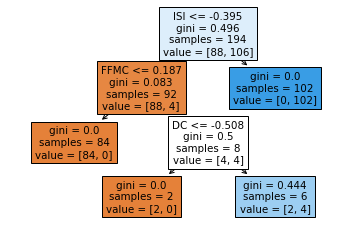

In [79]:
tree.plot_tree(dt, filled=True, feature_names=train_x.columns)

# 📌

Accuracy of model dt is 98.4%

## Naive Bayes

In [82]:
param_grid_nb={
    "var_smoothing": [1e-9,0.1, 0.001, 0.5,0.05,0.01,1e-8,1e-7,1e-6,1e-10,1e-11]
}

grid_search_nb = GridSearchCV(GaussianNB(), param_grid_nb, cv=5)
grid_search_nb.fit(train_x, train_y)
grid_search_nb.best_params_

{'var_smoothing': 1e-09}

In [83]:
nb=GaussianNB(var_smoothing=1e-9)
nb.fit(train_x, train_y)

GaussianNB()

In [84]:
pred_nb_y=nb.predict(test_x)

print('Confusion Matrix: \n',confusion_matrix(test_y, pred_nb_y))
score_nb=np.round(roc_auc_score(test_y, pred_nb_y), 3)
print('Accuracy Score: ', score_nb)

Confusion Matrix: 
 [[17  1]
 [ 2 29]]
Accuracy Score:  0.94


# 📌

Accuracy of model nb 94%

## RandomForest

In [87]:
param_grid_rf={
    "n_estimators" : [50,100,150,200],
    "criterion" : ["gini", "entropy"],
    "max_depth" : [2,3],
    "max_features" : ["sqrt", "log2", None],
    "random_state" : [10, 50, 120, 150]

}

grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5)
grid_search_rf.fit(train_x, train_y)
grid_search_rf.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'max_features': 'sqrt',
 'n_estimators': 100,
 'random_state': 10}

In [94]:
rf=RandomForestClassifier(criterion='gini', max_depth=2, max_features='sqrt', n_estimators=100, random_state=10)
rf.fit(train_x, train_y)

RandomForestClassifier(max_depth=2, max_features='sqrt', random_state=10)

In [95]:
pred_rf_y=rf.predict(test_x)

print('Confusion Matrix: \n',confusion_matrix(test_y, pred_rf_y))
score_rf=np.round(roc_auc_score(test_y, pred_rf_y),3)
print('Accuracy Score: ', score_rf)

Confusion Matrix: 
 [[18  0]
 [ 1 30]]
Accuracy Score:  0.984


# 📌

Accuracy of model rf is 98.4%

## Compairing Models

In [91]:
scores=[("LogisticRegression", score_lr), ("SVC", score_svc), ("DecissionTree" , score_dt), ("NaiveBayes" , score_nb), ("RandomForest" , score_rf)]
model_report=pd.DataFrame(scores, columns=['Model', 'Score'])

In [92]:
model_report

,Model,Score
0,LogisticRegression,0.968
1,SVC,0.940
2,DecissionTree,0.984
3,NaiveBayes,0.940
4,RandomForest,0.984


DecissionTree and RandomForest both have same accuracy. We are choosing RandomForest

## Saving best model

In [93]:
if not os.path.isdir('Models'):
    os.mkdir('Models')
pickle.dump(rf, open('Models/Model_Classification.pickle', 'wb'))